In [22]:
import os
import sys
import torch 
import pickle
import numpy as np
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

path = '../../gld/train-data-probes/data/6.9b'

In [23]:
# with open(os.path.join(path, 'mem_all_generations.pkl'), 'rb') as f:
#     generations = pickle.load(f)

with open(os.path.join(path, 'mem_all_mem_status.pkl'), 'rb') as f:
    status = pickle.load(f)

with open(os.path.join(path, 'pile_all_mem_status.pkl'), 'rb') as f:
    pile_status = pickle.load(f)

with open(os.path.join(path, 'mem_all_generations.pkl'), 'rb') as f:
    mem_all_generations = pickle.load(f)

with open(os.path.join(path, 'pile_all_generations.pkl'), 'rb') as f:
    pile_all_generations = pickle.load(f)

with open(os.path.join(path, 'mem_all_tokens.pkl'), 'rb') as f:
    mem_all_tokens = pickle.load(f)

with open(os.path.join(path, 'pile_all_tokens.pkl'), 'rb') as f:
    pile_all_tokens = pickle.load(f)

print(len(status), len(pile_status))
print(status.keys())

3 3
dict_keys(['lev_distance', 'char_by_char_sim', 'tok_by_tok_sim'])


In [24]:
def gen_pile_data(N, tokenizer, min_n_toks : int = None):
    pile = load_dataset('EleutherAI/the_pile_deduplicated', split='train', streaming=True)
    sentences = []

    counter = 0
    for i, example in enumerate(pile):
        if min_n_toks is not None:
            toks = tokenizer(example['text'])['input_ids']
            if len(toks) > min_n_toks:
                sentences.append(example['text'])
                counter +=1
        else:
            sentences.append(example['text'])
            counter +=1
        
        if counter == N:
            break

    return sentences

N_PROMPTS = 10000
model_name = "EleutherAI/pythia-6.9b"
dataset_name = "duped." + model_name.split("-")[-1]
tokenizer = AutoTokenizer.from_pretrained(model_name)

mem_data = load_dataset('EleutherAI/pythia-memorized-evals')[dataset_name]
mem_data_toks = [seq for seq in mem_data[:N_PROMPTS]['tokens']]
pile_prompts = gen_pile_data(N_PROMPTS, tokenizer, min_n_toks = 64)

print(len(pile_prompts))
print(len(mem_data_toks))
    
tok_idxs =  (7 * np.arange(10)).tolist() #every 5th token
tok_idxs[-1]= tok_idxs[-1] - 1 #goes from 63 to 62
print(tok_idxs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Resolving data files: 100%|██████████| 1650/1650 [00:00<00:00, 5199.81it/s]


10000
10000
[0, 7, 14, 21, 28, 35, 42, 49, 56, 62]


In [25]:
# import pandas as pd

# # # load from csv
# # df = pd.read_csv(os.path.join(path, 'mem_evals_gen_data.csv'))
# # mem_df = df[:len(status)]
# # pile_df = df[len(status):]

# # # sort mem df by mem_status col
# # mem_df = mem_df.sort_values(by=['char_by_char_similarity'], ascending=True)
# # pd.set_option('display.max_colwidth', None)
# # # mem_df.head(105)

# # create df

# source = ['pythia-evals' for _ in range(N_PROMPTS)] + ['pile' for _ in range(N_PROMPTS)]
# gen = mem_all_generations + pile_all_generations
# mem_str = tokenizer.batch_decode(mem_all_tokens, skip_special_tokens=True)
# ground = mem_str + pile_prompts
# mem_status = status['tok_by_tok_sim'] + pile_status['tok_by_tok_sim']
# char_status = status['char_by_char_sim'] + pile_status['char_by_char_sim']
# lev_status = status['lev_distance'] + pile_status['lev_distance']
# orig_index = [i for i in range(N_PROMPTS)] + [i for i in range(N_PROMPTS)]
# toks = mem_all_tokens + pile_all_tokens

# df = pd.DataFrame(list(zip(gen, ground, mem_status, char_status, lev_status, toks, source, orig_index)), 
#                columns =['gen', 'ground', 'tok_by_tok_sim', 'char_by_char_sim', 'lev_distance', 'toks', 'source', 'orig_index'])

# # count occurrences of '|' in gen 

# # print(df['gen'].str.count('|').sum())
# # print(df['ground'].str.count('|').sum())
# df.to_csv(os.path.join(path, 'mem_evals_gen_data.csv'), index=False, escapechar='\\')

In [26]:
import pandas as pd

df = pd.read_csv(os.path.join(path, 'mem_evals_gen_data.csv'), escapechar='\\')

# dedup according to gen
df = df.drop_duplicates(subset=['gen'])

len(df)

19722

In [27]:
# remove common patterns
from collections import Counter

def has_repeated_majority(arr, frac = 1/2):
    """
    Check if any value in the array is repeated more than half the length of the array.

    Parameters:
    arr (list): The input list of numbers.

    Returns:
    bool: True if a majority element exists, False otherwise.
    """
    if not arr:
        return False

    count = Counter(arr)
    length = len(arr)

    for key, value in count.items():
        if value > length * frac:
            return True

    return False

df['toks'] = df['toks'].apply(lambda x: eval(x))
rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if has_repeated_majority(row['toks'], frac=1/4):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

19722it [00:00, 20126.61it/s]

544


In [28]:
import re

def remove_punc(string):
    return re.sub(r'[\[\]._,\-]', '', string)

def remove_non_numeric(string):
    return re.sub(r'[^\d]', '', string)

def check_repeated_string(string):
    # Remove periods, underscores, dashes, and other special characters
    string = remove_punc(string)
    words = string.split()
    if len(words) == 0:
        return False
    else:
        return all(words[i] == words[i+1] for i in range(len(words)-1))
    
def check_increment(string):
    # Remove periods, underscores, dashes, and other special characters
    
    numbers = [int(remove_punc(word.strip())) for word in string.split() if remove_punc(word.strip()).isdigit()]
    if len(numbers) < 4:
        return False
    else:
        all_inc = all(numbers[i] == numbers[i+1] - 1 for i in range(len(numbers)-1)) 
        all_dec = all(numbers[i] ==  numbers[i+1] + 1 for i in range(len(numbers)-1))
        # alt_dec_0 = all(numbers[i] < numbers[i+1] for i in list(range(len(numbers)-1))[::2]) 
        # alt_inc_0 = all(numbers[i] > numbers[i+1] for i in list(range(len(numbers)-1))[::2])
        # all_dec_1 = all(numbers[i] < numbers[i+1] for i in list(range(len(numbers)-1))[1::2])
        # all_inc_1 = all(numbers[i] > numbers[i+1] for i in list(range(len(numbers)-1))[1::2])
        return all_inc or all_dec 
        # or alt_inc_0 or alt_dec_0 or alt_inc_0 or all_dec_1 or all_inc_1
    
rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if check_repeated_string(row['gen']) or check_increment(row['gen']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)


19178it [00:01, 11894.80it/s]

270


In [29]:
pile_df = df[df['source'] == 'pile']
mem_df = df[df['source'] == 'pythia-evals']

In [30]:
# char_similarity = []
# for i in tqdm(range(len(df))): 
#     gen = df['gen'][i]
#     ground = df['ground'][i]
    
#     # remove all whitespace 
#     gen = ''.join(gen.split())
#     ground = ''.join(ground.split())

#     # lowercase 
#     gen = gen.lower()
#     ground = ground.lower()

#     # remove '<|endoftext|>'
#     gen = gen.replace('<|endoftext|>', '')
#     ground = ground.replace('<|endoftext|>', '')

#     max_len = max(len(gen), len(ground))
#     matches = [c1 == c2 for c1, c2 in zip(gen, ground)]
#     char_similarity.append(sum(matches)/max_len if max_len > 0 else 0)

# df['char_by_char_similarity'] = char_similarity
# df.head()

# df.to_csv(os.path.join(path, 'mem_evals_gen_data.csv'), index=False)

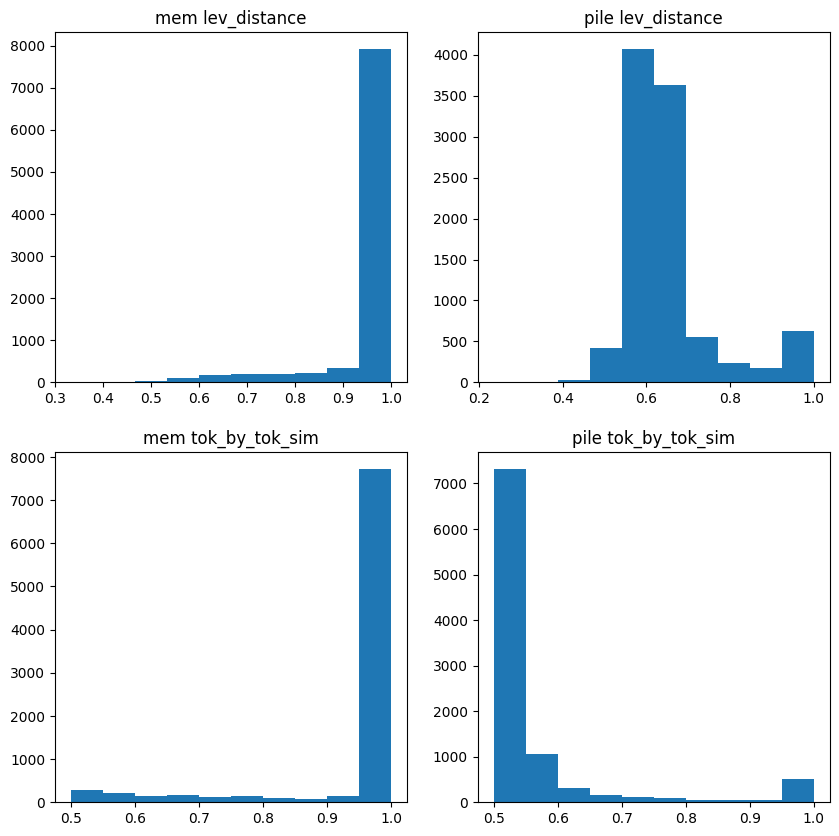

In [31]:
# hist of mem_status for each
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(mem_df['lev_distance'])
ax[0,1].hist(pile_df['lev_distance'])
ax[1,0].hist(mem_df['tok_by_tok_sim'])
ax[1,1].hist(pile_df['tok_by_tok_sim'])
ax[0,0].set_title('mem lev_distance')
ax[0,1].set_title('pile lev_distance')
ax[1,0].set_title('mem tok_by_tok_sim')
ax[1,1].set_title('pile tok_by_tok_sim')
plt.show()



### make train dataset

In [32]:
# # only keep pile_df with char_by_char_similarity = 0.5
# new_pile_df = pile_df[pile_df['char_by_char_similarity'] <= 0.55]
# extras = mem_df[mem_df['char_by_char_similarity'] <= 0.55]

# # only keep mem_df with char_by_char_similarity = 1.0
# new_mem_df = mem_df[mem_df['char_by_char_similarity'] == 1]

# print(len(new_mem_df), len(new_pile_df), len(extras))

neg = df[df['tok_by_tok_sim'] <= 0.55]
pos = df[df['tok_by_tok_sim'] == 1]

print(len(neg), len(pos))

min_len = min(len(neg), len(pos))
min_len = 5000

positive_idxs = pos.index.tolist()
negative_idxs = neg.index.tolist()

# sample 
import numpy as np
np.random.seed(0)
positive_idxs = np.random.choice(positive_idxs, min_len, replace=False)
negative_idxs = np.random.choice(negative_idxs, min_len, replace=False)

7614 7761


In [33]:
# show all col width
pd.set_option('display.max_colwidth', None)
# et font size bigger for pandas

pos.head(5)

,gen,ground,tok_by_tok_sim,char_by_char_sim,lev_distance,toks,source,orig_index
0,"xsd:string"" minOccurs=""0"" msdata:Ordinal=""1"" />\n <xsd:element name=""comment"" type=""xsd:string"" minOccurs=""0"" msdata:Ordinal=""2"" />\n </xsd:sequence>\n <xsd:attribute name","xsd:string"" minOccurs=""0"" msdata:Ordinal=""1"" />\n <xsd:element name=""comment"" type=""xsd:string"" minOccurs=""0"" msdata:Ordinal=""2"" />\n </xsd:sequence>\n <xsd:attribute name",1.0,1.0,1.0,"[18728, 27, 2703, 3, 1054, 26600, 2244, 568, 17, 3, 13818, 2203, 27, 45435, 989, 568, 18, 3, 4725, 187, 50262, 29, 18728, 27, 10531, 1416, 568, 13982, 3, 1511, 568, 18728, 27, 2703, 3, 1054, 26600, 2244, 568, 17, 3, 13818, 2203, 27, 45435, 989, 568, 19, 3, 4725, 187, 50264, 870, 18728, 27, 21934, 31, 187, 50264, 29, 18728, 27, 15810, 1416]",pythia-evals,0
3,cdcdc; text-align:center| Midfielders\n\n|-\n! colspan=10 style=background:#dcdcdc; text-align:center| Forwards\n\n|-\n! colspan=10 style=background:#dcdcdc; text-align:center| Players transferred out,cdcdc; text-align:center| Midfielders\n\n|-\n! colspan=10 style=background:#dcdcdc; text-align:center| Forwards\n\n|-\n! colspan=10 style=background:#dcdcdc; text-align:center| Players transferred out,1.0,1.0,1.0,"[2428, 2428, 68, 28, 2505, 14, 8623, 27, 9229, 93, 11864, 3423, 398, 187, 187, 9973, 187, 2, 41002, 30, 740, 3740, 30, 11814, 18459, 69, 2428, 2428, 68, 28, 2505, 14, 8623, 27, 9229, 93, 1198, 4515, 187, 187, 9973, 187, 2, 41002, 30, 740, 3740, 30, 11814, 18459, 69, 2428, 2428, 68, 28, 2505, 14, 8623, 27, 9229, 93, 32392, 9495, 562]",pythia-evals,3
4,"\n\t\t<read echo=""ascii""><delim>\n</delim><match><data>1) Send Message\n</data></match></read>\n\t\t<read echo=""ascii""><delim>\n</delim><match><data>2) Read Message\n</data></match></read>\n\t\t","\n\t\t<read echo=""ascii""><delim>\n</delim><match><data>1) Send Message\n</data></match></read>\n\t\t<read echo=""ascii""><delim>\n</delim><match><data>2) Read Message\n</data></match></read>\n\t\t",1.0,1.0,1.0,"[996, 186, 29, 1088, 7392, 568, 29860, 5264, 21694, 13544, 79, 870, 21694, 2730, 8992, 2730, 2203, 31, 18, 10, 23934, 17775, 61, 79, 870, 2203, 3073, 8992, 3073, 1088, 31, 996, 186, 29, 1088, 7392, 568, 29860, 5264, 21694, 13544, 79, 870, 21694, 2730, 8992, 2730, 2203, 31, 19, 10, 6707, 17775, 61, 79, 870, 2203, 3073, 8992, 3073, 1088, 31, 996, 186]",pythia-evals,4
6,copy = 3 + BITS(2);\n DROPBITS(2);\n }\n else if (here.val == 17) {\n NEEDBITS(here.bits + 3);\n DROPBITS(here.bits);\n len = 0;\n copy =,copy = 3 + BITS(2);\n DROPBITS(2);\n }\n else if (here.val == 17) {\n NEEDBITS(here.bits + 3);\n DROPBITS(here.bits);\n len = 0;\n copy =,1.0,1.0,1.0,"[12557, 426, 495, 559, 378, 24265, 9, 19, 558, 187, 50254, 4976, 2795, 39076, 9, 19, 558, 187, 50258, 94, 187, 50258, 7271, 604, 313, 1568, 15, 1208, 2295, 1722, 10, 551, 187, 50254, 6603, 1703, 39076, 9, 1568, 15, 11209, 559, 495, 558, 187, 50254, 4976, 2795, 39076, 9, 1568, 15, 11209, 558, 187, 50254, 5025, 426, 470, 28, 187, 50254, 12557, 426]",pythia-evals,6
7,"int slave,\n\t\t\t struct mlx4_vhcr *vhcr,\n\t\t\t struct mlx4_cmd_mailbox *inbox,\n\t\t\t struct mlx4_cmd_mailbox *outbox,\n\t\t\t struct mlx4_cmd_info *cmd)\n{\n\tstruct","int slave,\n\t\t\t struct mlx4_vhcr *vhcr,\n\t\t\t struct mlx4_cmd_mailbox *inbox,\n\t\t\t struct mlx4_cmd_mailbox *outbox,\n\t\t\t struct mlx4_cmd_info *cmd)\n{\n\tstruct",1.0,1.0,1.0,"[540, 15945, 13, 2657, 50272, 2855, 13361, 89, 21, 64, 42781, 7083, 475, 42781, 7083, 13, 2657, 50272, 2855, 13361, 89, 21, 64, 14111, 64, 5719, 3364, 475, 249, 3364, 13, 2657, 50272, 2855, 13361, 89, 21, 64, 14111, 64, 5719, 3364, 475, 483, 3364, 13, 2657, 50272, 2855, 13361, 89, 21, 64, 14111, 64, 5374, 475, 14111, 10, 187, 92, 187, 186, 2855]",pythia-evals,7


In [34]:
final_tokens = []
final_str = []
labels = []
for i in tqdm(positive_idxs): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)
for i in tqdm(negative_idxs):
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(0)

print(len(final_tokens), len(final_str), len(labels)), len(df)

100%|██████████| 5000/5000 [00:00<00:00, 97642.32it/s]

10000 10000 10000


(None, 18908)

In [35]:
print(sum(labels)/len(labels))  

0.5


In [36]:
# create a huggingface dataset
from datasets import Dataset
idxs = positive_idxs.tolist() + negative_idxs.tolist()
dataset = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': idxs})
dataset.save_to_disk(os.path.join(path, 'hf_token_dataset'))

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 472901.36 examples/s]


In [63]:
from datasets import load_from_disk, DatasetDict
import numpy as np

seed = 0
np.random.seed(seed)

path = '../../gld/train-data-probes/data/6.9b'
dataset = load_from_disk(os.path.join(path, 'hf_token_dataset'))

print(len(dataset))

dataset = dataset.shuffle(seed=seed)
dataset = dataset.train_test_split(test_size=0.3)
test = dataset['test']
temp = dataset['train'].train_test_split(test_size=1/7)
train = temp['train']
val = temp['test']
dataset = DatasetDict({'train': train, 'val': val, 'test': test})

# cutoff after 64 tokens
input_ids = {'train': [], 'val': [], 'test': []}
texts = {'train': [], 'val': [], 'test': []}
labels = {'train': [], 'val': [], 'test': []}
orig_idx = {'train': [], 'val': [], 'test': []}
for cutoff in tok_idxs[5:]: 
    print(cutoff)
    for split in ['train', 'val', 'test']:
        input_ids[split].extend([x[:cutoff] for x in dataset[split]['input_ids']])
        texts[split].extend(dataset[split]['text'])
        labels[split].extend(dataset[split]['labels'])
        orig_idx[split].extend(dataset[split]['orig_idx'])

dataset = DatasetDict({'train': Dataset.from_dict({'input_ids': input_ids['train'], 'text': texts['train'], 'labels': labels['train'], 'orig_idx': orig_idx['train']}),
                          'val': Dataset.from_dict({'input_ids': input_ids['val'], 'text': texts['val'], 'labels': labels['val'], 'orig_idx': orig_idx['val']}),
                          'test': Dataset.from_dict({'input_ids': input_ids['test'], 'text': texts['test'], 'labels': labels['test'], 'orig_idx': orig_idx['test']})})

10000
35
42
49
56
62


In [64]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 30000
    })
    val: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 15000
    })
})

In [65]:
dataset.save_to_disk(os.path.join(path, 'split_hf_token_dataset_vary_len'))

Saving the dataset (1/1 shards): 100%|██████████| 15000/15000 [00:00<00:00, 709120.17 examples/s]


### make generalization datasets

In [66]:
import numpy as np
seed = 0
np.random.seed(seed)

In [67]:
hard_pos = df[df['tok_by_tok_sim'] != 1]
hard_pos = hard_pos[hard_pos['tok_by_tok_sim'] >= 0.9]
                    
positive_idxs = hard_pos.index.tolist()

print(len(hard_pos))

667


In [68]:
hard_pos.sort_values(by=['tok_by_tok_sim'], ascending=True, inplace=True)

# hard_pos.head(10)

In [69]:
final_tokens = []
final_str = []
labels = []
for i in hard_pos.index.tolist(): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)

print(len(final_tokens), len(final_str), len(labels))

fuzzy_pos = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': hard_pos.index.tolist()})

667 667 667


In [70]:
from datasets import load_from_disk

test_dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len'))['test']

new_pile_sentences = gen_pile_data(20000, tokenizer, min_n_toks = 64)[10000:]

Resolving data files: 100%|██████████| 1650/1650 [00:00<00:00, 3496.77it/s]


In [ ]:
max_toks = 256
prefix_lens = [8,16,32,64,128,256]

new_pile_toks = []
for i in tqdm(range(len(new_pile_sentences))): 
    prompt = new_pile_sentences[i]
    toks = tokenizer(prompt)['input_ids']
    if len(toks) > max_toks:
        prefix_len = np.random.choice(prefix_lens)
        start_idx = np.random.choice(range(len(toks) - prefix_len))
        end_idx = start_idx + prefix_len
        toks = toks[start_idx:end_idx]
    new_pile_toks.append(toks)

100%|██████████| 10000/10000 [00:41<00:00, 242.76it/s]


In [ ]:
len(new_pile_toks), len(new_pile_toks[1024])

(10000, 128)

In [ ]:
new_line_tok = tokenizer('\n\n').input_ids

test_input_ids = test_dataset['input_ids']

for i in tqdm(range(len(test_input_ids))):
    prefix_idx = np.random.choice(range(len(new_pile_toks)))
    prefix = new_pile_toks[prefix_idx]
    test_input_ids[i] = prefix + new_line_tok + test_input_ids[i]

100%|██████████| 15000/15000 [00:08<00:00, 1815.88it/s]


In [56]:
prefix_dataset = Dataset.from_dict({'input_ids': test_input_ids, 'text': test_dataset['text'], 'labels': test_dataset['labels'], 'orig_idx': test_dataset['orig_idx']})

# prefix_dataset.save_to_disk(os.path.join(path, 'prefix_dataset_v0'))

In [60]:
from datasets import DatasetDict

generalization_datasets = DatasetDict({'fuzzy_pos': fuzzy_pos, 'prefix': prefix_dataset})
generalization_datasets.save_to_disk(os.path.join(path, 'generalization_datasets'))

Saving the dataset (1/1 shards): 100%|██████████| 15000/15000 [00:00<00:00, 520807.27 examples/s]


In [62]:
from datasets import load_from_disk

generalization_datasets = load_from_disk(os.path.join(path, 'generalization_datasets'))
generalization_datasets

DatasetDict({
    fuzzy_pos: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 667
    })
    prefix: Dataset({
        features: ['input_ids', 'labels', 'orig_idx'],
        num_rows: 15000
    })
})

## finetuning

In [4]:
# finetuning! 

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_name = 'EleutherAI/pythia-70m'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

id2label = {0: 'neg', 1: 'pos'} 
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
model.to('cuda')
model.config.pad_token_id = model.config.eos_token_id


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
path = '../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_v1'))

# dataset = dataset.shuffle(seed=seed)
# dataset = dataset.train_test_split(test_size=0.3)
# test = dataset['test']
# temp = dataset['train'].train_test_split(test_size=1/7)
# train = temp['train']
# val = temp['test']
# dataset = DatasetDict({'train': train, 'val': val, 'test': test})

# train_input_ids = dataset['train']['input_ids']
# val_input_ids = dataset['val']['input_ids']
# test_input_ids = dataset['test']['input_ids']

# # cutoff after 64 tokens
# train_input_ids = [tok[:64] for tok in train_input_ids]
# val_input_ids = [tok[:64] for tok in val_input_ids]
# test_input_ids = [tok[:64] for tok in test_input_ids]

# train_dataset = Dataset.from_dict({'input_ids': train_input_ids, 'labels': dataset['train']['labels']})
# val_dataset = Dataset.from_dict({'input_ids': val_input_ids, 'labels': dataset['val']['labels']})
# test_dataset = Dataset.from_dict({'input_ids': test_input_ids, 'labels': dataset['test']['labels']})

# dataset = DatasetDict({'train': train_dataset, 'val': val_dataset, 'test': test_dataset})

# dataset.save_to_disk(os.path.join(path, 'split_hf_token_dataset_v1'))

dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4047
    })
    val: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 675
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 2024
    })
})

In [6]:
def tpr_at_fpr(probs, labels, target_fpr, left=0.5, right=1.0, max_steps=1000, thresh_tol=1e-5): 
    """
    Calculates the true positive rate at a given false positive rate. 
    Does up to max_steps steps of binary search, returns the best guess 
    that yields a false positive rate less than target_fpr
    
    probs: (n_examples, ) just prob on positive class
    labels: (n_examples, ) 0 or 1
    """
    assert len(probs) == len(labels)
    assert probs.shape == labels.shape
    assert probs.shape[0] > 0

    for _ in range(max_steps):
        mid = (left + right) / 2
        
        # calc fpr 
        preds = (probs > mid).astype(int)
        fp = np.logical_and(preds == 1, labels == 0).sum()
        tn = (labels == 0).sum()
        fpr = fp / tn if tn > 0 else 0

        if abs(fpr - target_fpr) < thresh_tol: 
            right = mid
            break
        elif fpr > target_fpr:
            left = mid
        else:
            right = mid
    
    # use right as threshold to ensure fpr <= target_fpr
    preds = (probs > right).astype(int)
    tp = np.logical_and(preds == 1, labels == 1).sum()
    fn = (labels == 1).sum()
    return tp / fn if fn > 0 else 0
    

In [7]:
targs = TrainingArguments(
    output_dir = os.path.join(path, 'finetuning/'),
    evaluation_strategy = "epoch", 
    logging_strategy = "epoch",    
    learning_rate=1e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to='none',
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, positive_prob)

    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    # print(f'accuracy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}, AUC: {auc}')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

trainer = Trainer(
    model=model,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'], 
    compute_metrics=compute_metrics,
)

In [8]:
trainer.train()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.029200,0.624987,0.779259,0.835714,0.694362,0.758509,0.810502,0.127596,0.023739,0.023739
2,0.508300,0.529149,0.798519,0.801802,0.792285,0.797015,0.842783,0.192878,0.103858,0.103858
3,0.371400,0.512797,0.788148,0.841549,0.709199,0.769726,0.846988,0.225519,0.091988,0.091988


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (0), or the `sep_token_id` (None), and your input is not padded.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/my

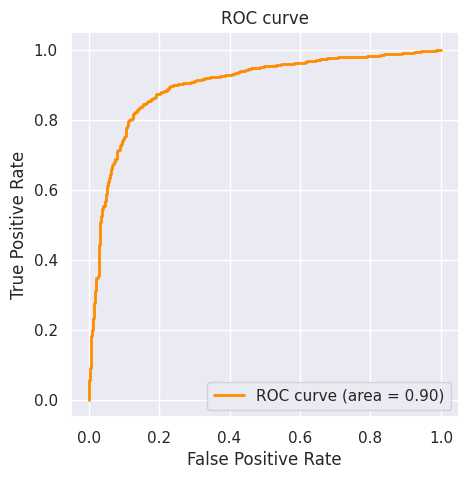

In [19]:
# plot
sns.set()
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


In [24]:
fpr

array([0.        , 0.        , 0.        , 0.00100806, 0.00100806,
       0.00201613, 0.00201613, 0.00302419, 0.00302419, 0.00403226,
       0.00403226, 0.00504032, 0.00504032, 0.00604839, 0.00604839,
       0.00604839, 0.00604839, 0.00705645, 0.00705645, 0.00705645,
       0.00705645, 0.00806452, 0.00806452, 0.01008065, 0.01008065,
       0.01108871, 0.01108871, 0.01108871, 0.01108871, 0.01209677,
       0.01209677, 0.01310484, 0.01310484, 0.0141129 , 0.0141129 ,
       0.01612903, 0.01612903, 0.0171371 , 0.0171371 , 0.01814516,
       0.01814516, 0.01915323, 0.01915323, 0.02016129, 0.02016129,
       0.02116935, 0.02116935, 0.02217742, 0.02217742, 0.02318548,
       0.02318548, 0.02419355, 0.02419355, 0.02620968, 0.02620968,
       0.02721774, 0.02721774, 0.02822581, 0.02822581, 0.02923387,
       0.02923387, 0.03024194, 0.03024194, 0.03125   , 0.03125   ,
       0.03225806, 0.03225806, 0.03326613, 0.03326613, 0.03427419,
       0.03427419, 0.03528226, 0.03528226, 0.03629032, 0.03629